In [1]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("/home/julien/stage/DL/data/train.csv")
df = df.sample(n=100000, random_state=42).reset_index(drop=True)  

In [2]:
# Concaténer texte + hashtags
df["full_text"] = (
    df["text"].fillna("") 
    #+ " " +
    #df["hashtags"].fillna("").str.replace(r"[^\w#]+", " ", regex=True)
)
#y = np.log1p(df["retweet_count"].values).astype(np.float32)
y = df["retweet_count"].values.astype(np.float32)

In [3]:

# Features numériques et scaler
num_cols = ["user_verified", "user_statuses_count", "user_followers_count", "user_friends_count"]
df["user_verified"] = df["user_verified"].astype(int)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols].values).astype(np.float32)




In [4]:
import nltk

from nltk.corpus import stopwords
# 1. Télécharger les stopwords NLTK (si pas déjà fait)
nltk.download("stopwords", quiet=True)

# 2. Récupérer les stopwords français et anglais
french_sw = set(stopwords.words("french"))
english_sw = set(stopwords.words("english"))

# 3. Faire l’union des deux ensembles
all_stopwords = french_sw.union(english_sw)

def simple_tokenizer(text):
    # 1. Mettre en minuscules
    text = text.lower()
    # 2. Supprimer les URLs (http://… ou https://…)
    text = re.sub(r"https?://\S+", "", text)
    # 3. Extraire les tokens alphanumériques
    tokens = re.findall(r"\w+", text)
    # 4. Filtrer tous les stopwords (français + anglais)
    filtered = [tok for tok in tokens if tok not in all_stopwords]
    # 5. Si aucun token n’est conservé, renvoyer "<unk>"
    return filtered if filtered else ["<unk>"]

from collections import Counter
counter = Counter(tok for txt in df["full_text"] for tok in simple_tokenizer(txt))
specials = ["<pad>","<unk>"]
topk = 50000
most_common_tokens = [tok for tok, freq in counter.most_common(topk)]
itos = specials + most_common_tokens
stoi = {tok:i for i,tok in enumerate(itos)}
pad_idx, unk_idx = stoi["<pad>"], stoi["<unk>"]

In [5]:
# 3) Dataset & DataLoader
from torch.utils.data import random_split
class TweetDataset(Dataset):
    def __init__(self, texts, numerics, labels):
        self.texts, self.numerics, self.labels = texts, numerics, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        toks = simple_tokenizer(self.texts[i]) or ["<unk>"]
        token_ids = [stoi.get(t, unk_idx) for t in toks]
        return {
            "tokens":    torch.tensor(token_ids, dtype=torch.long),
            "numerics":  torch.tensor(self.numerics[i], dtype=torch.float32),
            "label":     torch.tensor(self.labels[i], dtype=torch.float32),
        }


def collate_fn(batch):
    seqs = [b["tokens"] for b in batch]
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded  = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    nums    = torch.stack([b["numerics"] for b in batch])
    labs    = torch.stack([b["label"]    for b in batch])
    return padded, lengths, nums, labs

# split 80/20
texts = df["full_text"].tolist()
full_ds = TweetDataset(texts, X_num, y)
n_train = int(0.8 * len(full_ds))
n_valid = int(0.1 * len(full_ds))
n_test  = len(full_ds) - n_train - n_valid
train_ds, valid_ds, test_ds = random_split(full_ds,[n_train, n_valid, n_test],
    generator=torch.Generator().manual_seed(42))

batch_size = 512*4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



In [6]:
import torch
import torch.nn as nn

class LSTM_MLP(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim=300,
        lstm_hid=512,
        num_feat_dim=4,
        lstm_layers=1,
        bidirectional=True,
        dropout_emb=0.4,
        dropout_lstm=0.4,
        dropout_num=0.4,
        dropout_head=0.4,
        use_pooling="mean"  # ou "mean" ou "last"
    ):
        super().__init__()

        self.bidirectional = bidirectional
        self.lstm_hid = lstm_hid
        self.num_directions = 2 if bidirectional else 1
        self.use_pooling = use_pooling

        # 1) Embedding + Dropout
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(dropout_emb)

        # 2) LSTM multi-couches, bidirectionnel
        self.lstm = nn.LSTM(
            emb_dim,
            lstm_hid,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_lstm if lstm_layers > 1 else 0.0
        )

        # 3) MLP pour features numériques (BatchNorm + residual)
        self.num_mlp = nn.Sequential(
            nn.Linear(num_feat_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_num),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_num),
        )

        # 4) Tête de fusion
        fusion_dim = self.num_directions * lstm_hid + 64
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_head),
            nn.Linear(64, 1)
        )

        # 5) Initialisation explicite
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name and param.dim() > 1:
                nn.init.xavier_normal_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, tokens, lengths, numerics):
        """
        tokens   : LongTensor (B, L_max)
        lengths  : LongTensor (B,) avec la longueur réelle de chaque séquence
        numerics : FloatTensor (B, num_feat_dim)
        """
        # --- 1) Embedding + dropout ---
        emb = self.embedding(tokens)            # (B, L_max, emb_dim)
        emb = self.emb_dropout(emb)

        # --- 2) Pack et passage LSTM ---
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out_p, (h_n, c_n) = self.lstm(packed)

        # --- 3) On récupère la représentation texte selon l’option ---
        if self.use_pooling == "last":
            # On concatène les directions si bidirectionnel, sinon on prend h_n[-1]
            if self.bidirectional:
                # h_n shape = (2 * num_layers, B, lstm_hid)
                # On veut la dernière couche pour chaque direction :
                # indices -2 (aller) et -1 (retour)
                hidden_forward = h_n[-2]   # (B, lstm_hid)
                hidden_backward = h_n[-1]  # (B, lstm_hid)
                text_repr = torch.cat([hidden_forward, hidden_backward], dim=1)  # (B, 2*lstm_hid)
            else:
                # Si non bidir, h_n[-1] a déjà shape (B, lstm_hid)
                text_repr = h_n[-1]  # (B, lstm_hid)

        else:
            # on unpack pour pooling
            out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(out_p, batch_first=True)
            # out_unpacked shape = (B, L_max_eff, num_directions * lstm_hid)
            mask = (tokens != pad_idx).unsqueeze(-1)  # (B, L_max_eff, 1)

            if self.use_pooling == "max":
                # Max pooling sur la dimension temporelle
                out_unpacked_masked = out_unpacked.masked_fill(~mask, float("-inf"))
                text_repr, _ = out_unpacked_masked.max(dim=1)  # (B, num_directions*lstm_hid)

            elif self.use_pooling == "mean":
                # Mean pooling (somme / longueur)
                summed = (out_unpacked * mask.float()).sum(dim=1)        # somme uniquement sur tokens réels
                lengths_ = lengths.unsqueeze(1).float()                  # (B,1)
                text_repr = summed / lengths_                            # (B, num_directions*lstm_hid)

            else:
                raise ValueError(f"Pooling inconnu : {self.use_pooling}")

        # --- 4) Passage du MLP numérique ---
        num_repr = self.num_mlp(numerics)  # (B, 64)

        # --- 5) Fusion et sortie ---
        x = torch.cat([text_repr, num_repr], dim=1)    # (B, fusion_dim)
        out = self.head(x).squeeze(1)                  # (B,)

        return out


In [ ]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = LSTM_MLP(len(itos)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.L1Loss() 

n_epochs  = 20

train_losses = []
val_losses   = []
# ——— Entraînement ———
for epoch in range(1, n_epochs+1):
    model.train()
    total_train_loss = 0.0

    for tokens, lengths, numerics, labels in train_loader:
        tokens, lengths = tokens.to(device), lengths.to(device)
        numerics, labels = numerics.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(tokens, lengths, numerics)
        loss  = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * tokens.size(0)

    avg_train_loss = total_train_loss / len(train_ds)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch}/{n_epochs} — Train L1: {avg_train_loss:.4f}")

# ——— Validation ———
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for tokens, lengths, numerics, labels in valid_loader:
            tokens, lengths = tokens.to(device), lengths.to(device)
            numerics, labels = numerics.to(device), labels.to(device)

            preds = model(tokens, lengths, numerics)
            total_valid_loss += criterion(preds, labels).item() * tokens.size(0)
    avg_valid_loss = total_valid_loss / len(test_ds)
    val_losses.append(avg_valid_loss)
    print(f"Epoch {epoch}/{n_epochs} — Valid L1: {avg_valid_loss:.4f}")




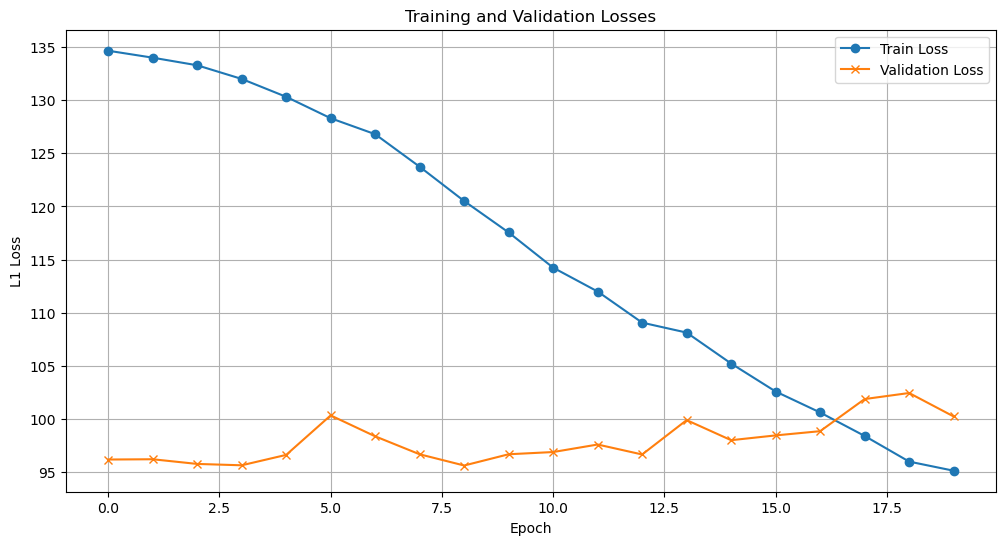

In [ ]:
# plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ——— Évaluation finale sur test set ———
model.eval()
total_test_loss = 0.0
criterion = nn.L1Loss()  # Utiliser MAE pour l'évaluation finale

with torch.no_grad():
    for tokens, lengths, numerics, labels in test_loader:
        tokens, lengths = tokens.to(device), lengths.to(device)
        numerics, labels = numerics.to(device), labels.to(device)

        preds = model(tokens, lengths, numerics)
        total_test_loss += criterion(preds, labels).item() * tokens.size(0)

avg_test_loss = total_test_loss / len(test_ds)
print(f"Final Test L1: {avg_test_loss:.4f}")


Final Test L1: 139.3942
